In [1]:
## 동적자산배분전략(VAA)을 활용해 포트폴리오 성과에 엣지를 더할 수 있습니다.

In [2]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json
import numpy as np

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [3]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf
from quant_functions import anal_funcs
import portfolio_obtimizer

In [4]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## DataLoad

In [43]:
dataset = pd.read_csv('trend_data.csv', index_col=0)
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset['2010':]

In [44]:
assets = ['SPY', 'TLT', 'IAU']

In [45]:
port_df = dataset[assets].copy()

In [46]:
temp_df = port_df.copy()
temp_df['Peak'] = temp_df[assets[0]].cummax()
temp_df['Drawdown'] = (temp_df[assets[0]] - temp_df['Peak']) / temp_df['Peak']
temp_df['Signal'] = np.nan
temp_df['Signal'][temp_df['Drawdown'] <= -0.2] = 1
temp_df['Signal'][temp_df['Drawdown'] == 0] = 0
temp_df['Signal'] = temp_df['Signal'].fillna(method='ffill')

In [47]:
rets_df = port_df.pct_change().fillna(0)

laa_res = ((rets_df * [0.35, 0.3, 0.35]).sum(1) + 1).cumprod()
vaa_res = (pd.concat([rets_df[temp_df['Signal'] == 0] * [0.35, 0.3, 0.35],
           rets_df[temp_df['Signal'] == 1] * [1, 0, 0]]).sort_index().sum(1) + 1).cumprod()

In [48]:
result  = pd.DataFrame({'LAA': laa_res, 'VAA': vaa_res})

<Axes: xlabel='Date'>

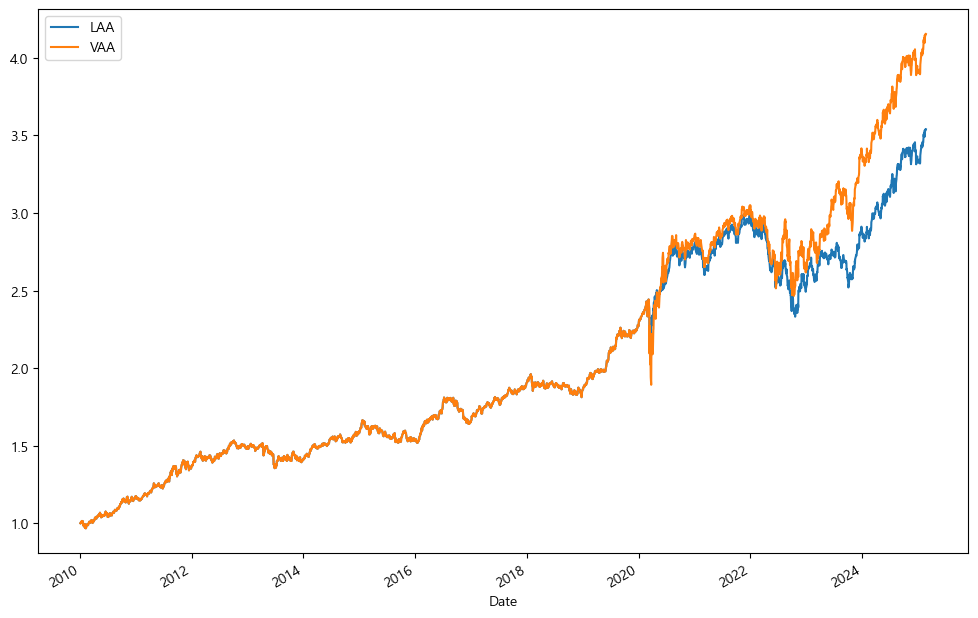

In [49]:
result.plot()